<a href="https://colab.research.google.com/github/lalmark/CvTask/blob/main/Diarization2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import pickle
import warnings
import librosa
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.mixture import *
from matplotlib import pyplot as plt
import numpy as np
import soundfile as sf

In [5]:
wavFile="6313.mp3"
wav,_ = librosa.load(wavFile,sr=16000)
sf.write('6313.wav', wav, 16000, 'PCM_16')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [12]:
segLen,frameRate,numMix = 3,50,128

In [7]:
def VoiceActivityDetection(wavData, frameRate):
    # uses the librosa library to compute short-term energy
    ste = librosa.feature.rms(wavData,hop_length=int(16000/frameRate)).T
    thresh = 0.1*(np.percentile(ste,97.5) + 9*np.percentile(ste,2.5))    # Trim 5% off and set threshold as 0.1x of the ste range
    return (ste>thresh).astype('bool')

In [8]:
wavFile="6313.wav"

In [24]:
wavData,_ = librosa.load(wavFile,sr=16000)
%time vad=VoiceActivityDetection(wavData,frameRate)

In [25]:
mfcc = librosa.feature.mfcc(wavData, sr=16000, n_mfcc=20,hop_length=int(16000/frameRate)).T
vad = np.reshape(vad,(len(vad),))
if mfcc.shape[0] > vad.shape[0]:
    vad = np.hstack((vad,np.zeros(mfcc.shape[0] - vad.shape[0]).astype('bool'))).astype('bool')
elif mfcc.shape[0] < vad.shape[0]:
    vad = vad[:mfcc.shape[0]]
mfcc = mfcc[vad,:];

In [11]:
n_components = np.arange(1, 25)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(mfcc)
          for n in n_components]

CPU times: user 4.02 s, sys: 2.36 s, total: 6.38 s
Wall time: 3.33 s


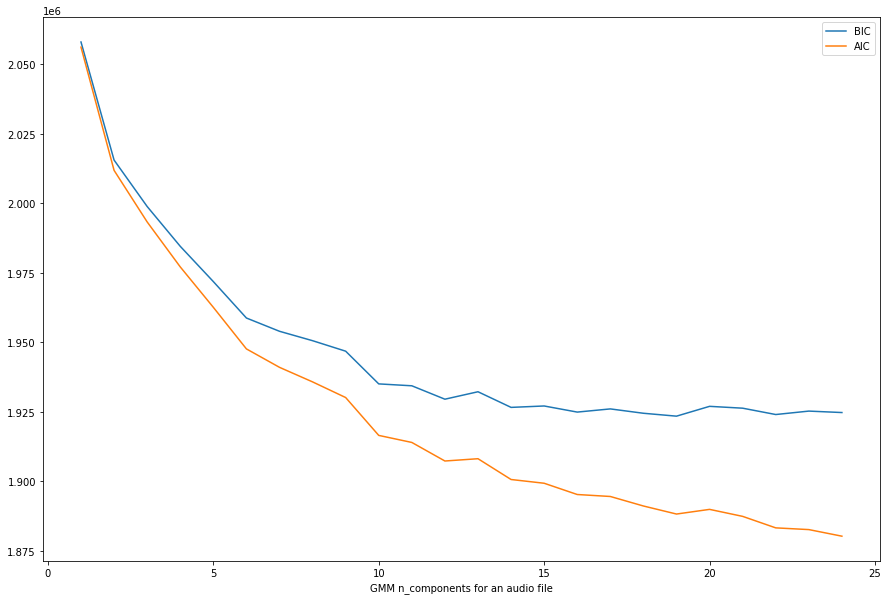

In [27]:
plt.figure(figsize=(15, 10))
plt.plot(n_components, [m.bic(mfcc) for m in models], label='BIC')
plt.plot(n_components, [m.aic(mfcc) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('GMM n_components for an audio file');

In [14]:
def trainGMM(wavFile, frameRate, segLen, vad, numMix):
    wavData,_ = librosa.load(wavFile,sr=16000)
    mfcc = librosa.feature.mfcc(wavData, sr=16000, n_mfcc=20,hop_length=int(16000/frameRate)).T
    vad = np.reshape(vad,(len(vad),))
    if mfcc.shape[0] > vad.shape[0]:
        vad = np.hstack((vad,np.zeros(mfcc.shape[0] - vad.shape[0]).astype('bool'))).astype('bool')
    elif mfcc.shape[0] < vad.shape[0]:
        vad = vad[:mfcc.shape[0]]
    mfcc = mfcc[vad,:];
    print("Training GMM..")
    GMM = GaussianMixture(n_components=numMix,covariance_type='diag').fit(mfcc)
    var_floor = 1e-5
    segLikes = []
    segSize = frameRate*segLen
    for segI in range(int(np.ceil(float(mfcc.shape[0])/(frameRate*segLen)))):
        startI = segI*segSize
        endI = (segI+1)*segSize
        if endI > mfcc.shape[0]:
            endI = mfcc.shape[0]-1
        if endI==startI:    # Reached the end of file
            break
        seg = mfcc[startI:endI,:]
        compLikes = np.sum(GMM.predict_proba(seg),0)
        segLikes.append(compLikes/seg.shape[0])
    print("Training Done")

    return np.asarray(segLikes)

In [15]:
clusterset = trainGMM(wavFile, frameRate, segLen, vad, numMix)

Training GMM..
Training Done


In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clusterset)  
# Normalizing the data so that the data approximately 
# follows a Gaussian distribution
X_normalized = normalize(X_scaled)

In [17]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward') 
clust=cluster.fit_predict(X_normalized)

In [18]:
def SegmentFrame(clust, segLen, frameRate, numFrames):
    frameClust = np.zeros(numFrames)
    for clustI in range(len(clust)-1):
        frameClust[clustI*segLen*frameRate:(clustI+1)*segLen*frameRate] = clust[clustI]*np.ones(segLen*frameRate)
    frameClust[(clustI+1)*segLen*frameRate:] = clust[clustI+1]*np.ones(numFrames-(clustI+1)*segLen*frameRate)
    return frameClust

In [19]:
frameClust = SegmentFrame(clust, segLen, frameRate, mfcc.shape[0])

In [20]:
def speakerdiarisationdf(hyp, frameRate, wavFile):
    audioname=[]
    starttime=[]
    endtime=[]
    speakerlabel=[]
            
    spkrChangePoints = np.where(hyp[:-1] != hyp[1:])[0]
    if spkrChangePoints[0]!=0 and hyp[0]!=-1:
        spkrChangePoints = np.concatenate(([0],spkrChangePoints))
    spkrLabels = []    
    for spkrHomoSegI in range(len(spkrChangePoints)):
        spkrLabels.append(hyp[spkrChangePoints[spkrHomoSegI]+1])
    for spkrI,spkr in enumerate(spkrLabels[:-1]):
        if spkr!=-1:
            audioname.append(wavFile.split('/')[-1].split('.')[0]+".wav")
            starttime.append((spkrChangePoints[spkrI]+1)/float(frameRate))
            endtime.append((spkrChangePoints[spkrI+1]-spkrChangePoints[spkrI])/float(frameRate))
            speakerlabel.append("Speaker "+str(int(spkr)))
    if spkrLabels[-1]!=-1:
        audioname.append(wavFile.split('/')[-1].split('.')[0]+".wav")
        starttime.append(spkrChangePoints[-1]/float(frameRate))
        endtime.append((len(hyp) - spkrChangePoints[-1])/float(frameRate))
        speakerlabel.append("Speaker "+str(int(spkrLabels[-1])))
    #
    speakerdf=pd.DataFrame({"Audio":audioname,"starttime":starttime,"endtime":endtime,"speakerlabel":speakerlabel})
    
    spdatafinal=pd.DataFrame(columns=['Audio','SpeakerLabel','StartTime','EndTime'])
    i=0
    k=0
    j=0
    spfind=""
    stime=""
    etime=""
    for row in speakerdf.itertuples():
        if(i==0):
            spfind=row.speakerlabel
            stime=row.starttime
        else:
            if(spfind==row.speakerlabel):
                etime=row.starttime        
            else:
                spdatafinal.loc[k]=[wavFile.split('/')[-1].split('.')[0]+".wav",spfind,stime,row.starttime]
                k=k+1
                spfind=row.speakerlabel
                stime=row.starttime
        i=i+1
    spdatafinal.loc[k]=[wavFile.split('/')[-1].split('.')[0]+".wav",spfind,stime,etime]
    return spdatafinal
    

In [21]:
pass1hyp = -1*np.ones(len(vad))
pass1hyp[vad] = frameClust
spkdf=speakerdiarisationdf(pass1hyp, frameRate, "test2.wav")

In [22]:
spkdf["TimeSpeech"]=spkdf.EndTime-spkdf.StartTime

In [23]:
spkdf

,Audio,SpeakerLabel,StartTime,EndTime,TimeSpeech
0,test2.wav,Speaker 1,1.50,8.28,6.78
1,test2.wav,Speaker 0,8.28,156.88,148.60
2,test2.wav,Speaker 1,156.88,165.66,8.78
3,test2.wav,Speaker 0,165.66,216.84,51.18
4,test2.wav,Speaker 1,216.84,221.32,4.48
5,test2.wav,Speaker 0,221.32,232.84,11.52
6,test2.wav,Speaker 1,232.84,241.22,8.38
7,test2.wav,Speaker 0,241.22,310.68,69.46
8,test2.wav,Speaker 1,310.68,315.20,4.52
9,test2.wav,Speaker 0,315.20,393.58,78.38
